In [1]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

In [2]:
start_time = 0
end_time = 60 * 60 * 24 * 300
num_sellers = 15
num_buyers = 15

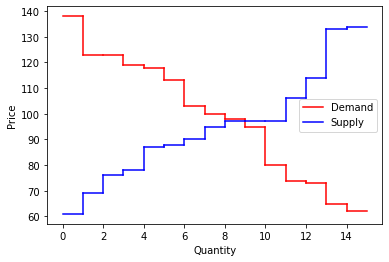

In [3]:
sup_range = (60, 140)
dem_range = (60, 140)

supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'random'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'random'}]
plot_sup_dem(num_sellers, [sup_range], num_buyers, [dem_range], 'random')

In [4]:
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

In [5]:
sellers_spec = [('PRSH', 30, {'k':4, 's_min':-1.0, 's_max': 1.0})]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

In [6]:
# sellers_spec = [('ZIP', 3), ('SHVR', 3), ('GVWY', 3), ('SNPR', 3)]
# num_sellers = 12
# buyers_spec = [('ZIP', 3), ('ZIC', 3), ('SHVR', 3), ('GVWY', 3)]
# num_buyers = 12
# traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

In [ ]:
trial = 2
trials=5
# while trial<trials :
trial_id = 'exp'+ str(trial)
tdump = open('exp'+ str(trial) +'_avg_balance.csv','w')
dump_all = True
verbose = False
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)
tdump.close()
#     trial+=1
    
# plot_trades('test_3')

B00: PRSH active_strat=[0]:
[0]: s=-0.058310, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.039163, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.085428, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.056609, start=0.000000, $=0.000000, pps=0.000000


B01: PRSH active_strat=[0]:
[0]: s=+0.784739, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.751990, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.756883, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.730823, start=0.000000, $=0.000000, pps=0.000000


B02: PRSH active_strat=[0]:
[0]: s=+0.128951, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.140223, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.116630, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.148172, start=0.000000, $=0.000000, pps=0.000000


B03: PRSH active_strat=[0]:
[0]: s=-0.674427, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.714286, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.654716, start=0.000000, $=0.000000, pps=0.0000